## Imports & Load Dataset

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Load the ODI ball-by-ball data from CSV
odi_df = pd.read_csv('BAN_IND.csv')

# Optional: Set display options to inspect all data if needed
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

In [69]:
odi_df.head(2)

,Date,Batting Team,Bowling Team,Striker,Non-Striker,Bowler,Innings,Unique,Over Number,Over Ball,Runs,Wides,Team Runs,Remaining Overs,Lead By,Trail By,Fall Of Wickets,Day,Session,Leg Byes,No Balls,Balls,Byes,Remaining Balls,Remaining Runs,Run Rate,Batter Sixes,Batter Runs,Batter Fours,Batter Balls,Batter Total Runs,Dismissal Type,Dismissal Fielder,On Field Minutes,Shot Angle,Shot Magnitude,Wagon Position,Pitching Length,Pitching Line,Shot Connection,False Shot,Feet Movement,Shot Type,Delivery Type,Bowling Side,Bowling Type,Bowling Hand,Catch Difficulty
0,21-02-2025 13:00,Bangladesh,India,Tanzid Hasan,Soumya Sarkar,Mohammed Shami,1,0.1,1,1,1,0,1,49.5,0,0,0,1,1,0,0,1,0,299,NaN,6.0,0,1,0,1,1,NaN,NaN,0,165,99,Backward Square Leg,Length Delivery,Outside Off,Inside Edge,1,Back Foot,Drive,Straight Ball,Round,Fast,Right,0
1,21-02-2025 13:00,Bangladesh,India,Soumya Sarkar,Tanzid Hasan,Mohammed Shami,1,0.2,1,2,0,0,1,49.4,0,0,0,1,1,0,0,2,0,298,NaN,3.0,0,0,0,1,0,NaN,NaN,0,90,48,Wicketkeeper,Length Delivery,Outside Off,Missed,1,Back Foot,Drive,Out Swing,Round,Fast,Right,0


## Data Preprocessing

In [70]:
# Calculate extra runs from wides, leg byes, no balls, and byes.
odi_df['extras'] = odi_df['Wides'] + odi_df['Leg Byes'] + odi_df['No Balls'] + odi_df['Byes']

# Compute total runs scored on each ball (runs from bat plus extras).
odi_df['total_runs'] = odi_df['Runs'] + odi_df['extras']

# Flag a wicket by checking if 'Dismissal Type' is not empty.
odi_df['isOut'] = odi_df['Dismissal Type'].apply(lambda x: 1 if pd.notnull(x) and x != '' else 0)

# Create a unified ball identifier by combining 'Over Number' and 'Over Ball'.
# For example, Over Number 10 and Over Ball 2 becomes 10.2.
odi_df['ball'] = odi_df['Over Number'].astype(str) + '.' + odi_df['Over Ball'].astype(str)
odi_df['ball'] = odi_df['ball'].astype(float)

## Selecting Teams & Splitting Innings

In [71]:
# Define the teams.
t1 = 'Bangladesh'   # Batting first (1st innings)
t2 = 'India'        # Batting second (2nd innings)

# Filter the data for matches between these two teams.
mdf = odi_df[
    ((odi_df['Batting Team'] == t1) & (odi_df['Bowling Team'] == t2)) |
    ((odi_df['Batting Team'] == t2) & (odi_df['Bowling Team'] == t1))
].copy()

# Split the data into two innings.
df_ing1 = mdf[(mdf['Innings'] == 1) & (mdf['Batting Team'] == t1)].sort_values('ball').reset_index(drop=True)
df_ing2 = mdf[(mdf['Innings'] == 2) & (mdf['Batting Team'] == t2)].sort_values('ball').reset_index(drop=True)

# Get final scores using the 'Team Runs' column (last ball of each innings).
ing1_actual_score = int(df_ing1['Team Runs'].iloc[-1])  # For example, 228
ing2_actual_score = int(df_ing2['Team Runs'].iloc[-1])  # Final score for India, if available

# India's target is one run more than Bangladesh's final score.
target = ing1_actual_score + 1

print(f"{t1} final score:", ing1_actual_score)
print(f"{t2} target is:", target)

Bangladesh final score: 228
India target is: 229


## Setting Outcome Probabilities

In [72]:
# Define possible outcomes: runs (0, 1, 2, 3, 4, 6) and a wicket ('w').
outcomes = [0, 1, 2, 3, 4, 6, 'w']

# --- For Bangladesh (Team t1) ---
t1_df = odi_df[odi_df['Batting Team'] == t1]
t1_outcomes = t1_df['total_runs'].value_counts()
t1_outcomes_count = []
for outcome in outcomes:
    if outcome != 'w':
        t1_outcomes_count.append(t1_outcomes.get(outcome, 0))
    else:
        t1_outcomes_count.append(t1_df['isOut'].sum())
# Convert counts to probabilities.
t1_pb = [cnt / sum(t1_outcomes_count) for cnt in t1_outcomes_count]
# Compute cumulative probabilities.
t1_cum_pb = list(np.cumsum(t1_pb))

# --- For India (Team t2) ---
t2_df = odi_df[odi_df['Batting Team'] == t2]
t2_outcomes = t2_df['total_runs'].value_counts()
t2_outcomes_count = []
for outcome in outcomes:
    if outcome != 'w':
        t2_outcomes_count.append(t2_outcomes.get(outcome, 0))
    else:
        t2_outcomes_count.append(t2_df['isOut'].sum())
t2_pb = [cnt / sum(t2_outcomes_count) for cnt in t2_outcomes_count]
t2_cum_pb = list(np.cumsum(t2_pb))

## Define Simulation Functions

In [73]:
def innings_1_runs(curr_overs, curr_score, curr_wickets):
    """
    Simulate the remainder of the first innings (Bangladesh) from the current match state.
    """
    # Retrieve cumulative probabilities for Bangladesh's outcomes.
    i1p_0 = t1_cum_pb[0]
    i1p_1 = t1_cum_pb[1]
    i1p_2 = t1_cum_pb[2]
    i1p_3 = t1_cum_pb[3]
    i1p_4 = t1_cum_pb[4]
    i1p_6 = t1_cum_pb[5]
    
    pred_runs = curr_score
    pred_wks = curr_wickets

    # Convert current overs (e.g., 10.2) to total balls bowled.
    over_str = str(curr_overs)
    if '.' in over_str:
        over_num, ball_num = over_str.split('.')
        over_num = int(over_num)
        ball_num = int(ball_num)
    else:
        over_num = int(over_str)
        ball_num = 0
    current_balls = over_num * 6 + ball_num

    leftover_balls = 300 - current_balls  # Total balls in a 50-over match.

    for i in range(leftover_balls):
        r_value = np.random.random()
        if r_value <= i1p_0:
            pred_runs += 0
        elif r_value <= i1p_1:
            pred_runs += 1
        elif r_value <= i1p_2:
            pred_runs += 2
        elif r_value <= i1p_3:
            pred_runs += 3
        elif r_value <= i1p_4:
            pred_runs += 4
        elif r_value <= i1p_6:
            pred_runs += 6
        else:
            # A wicket falls.
            pred_wks += 1
            if pred_wks == 10:
                break

    return pred_runs

def innings_2_runs(curr_overs, curr_score, curr_wickets, target):
    """
    Simulate the remainder of the second innings (India) from the current match state.
    """
    i2p_0 = t2_cum_pb[0]
    i2p_1 = t2_cum_pb[1]
    i2p_2 = t2_cum_pb[2]
    i2p_3 = t2_cum_pb[3]
    i2p_4 = t2_cum_pb[4]
    i2p_6 = t2_cum_pb[5]

    pred_runs = curr_score
    pred_wks = curr_wickets

    over_str = str(curr_overs)
    if '.' in over_str:
        over_num, ball_num = over_str.split('.')
        over_num = int(over_num)
        ball_num = int(ball_num)
    else:
        over_num = int(curr_overs)
        ball_num = 0
    current_balls = over_num * 6 + ball_num

    leftover_balls = 300 - current_balls

    for i in range(leftover_balls):
        r_value = np.random.random()
        if r_value <= i2p_0:
            pred_runs += 0
        elif r_value <= i2p_1:
            pred_runs += 1
        elif r_value <= i2p_2:
            pred_runs += 2
        elif r_value <= i2p_3:
            pred_runs += 3
        elif r_value <= i2p_4:
            pred_runs += 4
        elif r_value <= i2p_6:
            pred_runs += 6
        else:
            # A wicket falls.
            pred_wks += 1
            if pred_wks == 10:
                break

        # Stop simulation if target is reached.
        if pred_runs >= target:
            break

    return pred_runs


## Runs prediction chart: 1st Innings

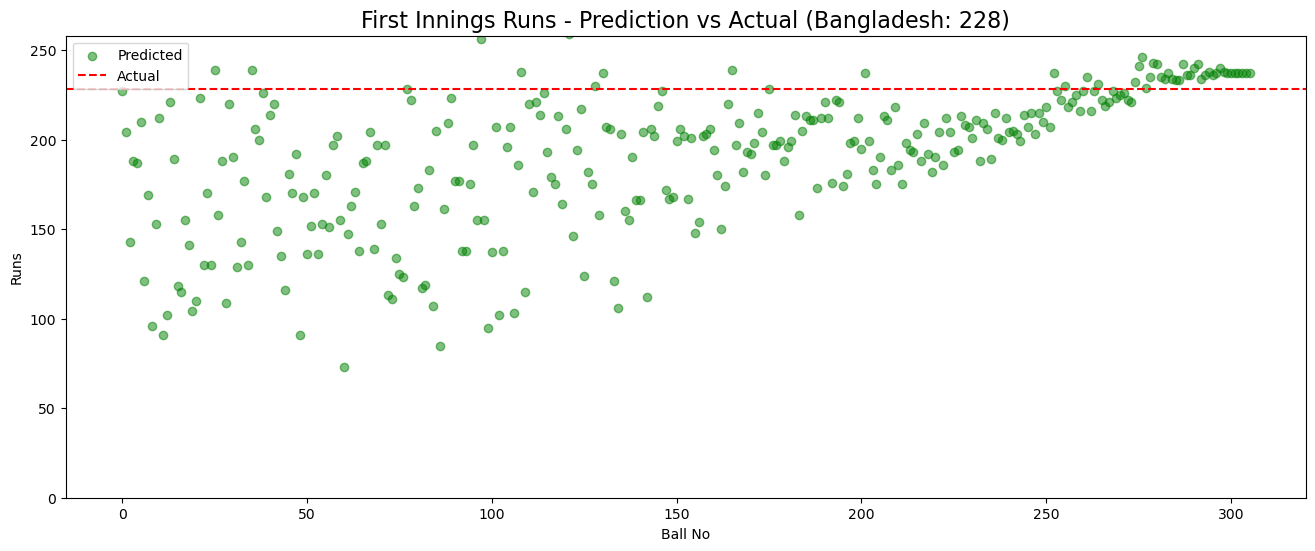

In [74]:
# Predict final score for each ball in the first innings (Bangladesh).
ing1_runs_pred = []
curr_score = 0
curr_wickets = 0
curr_overs = 0.0

for i in range(len(df_ing1)):
    curr_score += df_ing1.loc[i, 'total_runs']
    curr_wickets += df_ing1.loc[i, 'isOut']
    curr_overs = df_ing1.loc[i, 'ball']
    
    prediction = innings_1_runs(curr_overs, curr_score, curr_wickets)
    ing1_runs_pred.append(prediction)

# Plot the first innings runs prediction.
plt.figure(figsize=(16, 6))
# Scatter plot in GREEN for predicted runs.
plt.scatter(range(len(ing1_runs_pred)), ing1_runs_pred, alpha=0.5, color='green', label='Predicted')
# Actual final score shown as a RED horizontal line.
plt.axhline(ing1_actual_score, linestyle='--', color='red', label='Actual')
plt.ylim(0, ing1_actual_score + 30)
plt.title(f'First Innings Runs - Prediction vs Actual ({t1}: {ing1_actual_score})', fontsize=16)
plt.xlabel('Ball No')
plt.ylabel('Runs')
plt.legend()
plt.show()

## Error in 1st Innings runs:

In [75]:
# Calculate and print the mean absolute error for the first innings predictions.
error_ing1 = np.mean([abs(x - ing1_actual_score) for x in ing1_runs_pred])
print("Error in 1st Innings runs:", error_ing1)

Error in 1st Innings runs: 40.532679738562095


## Runs prediction chart: 2nd Innings

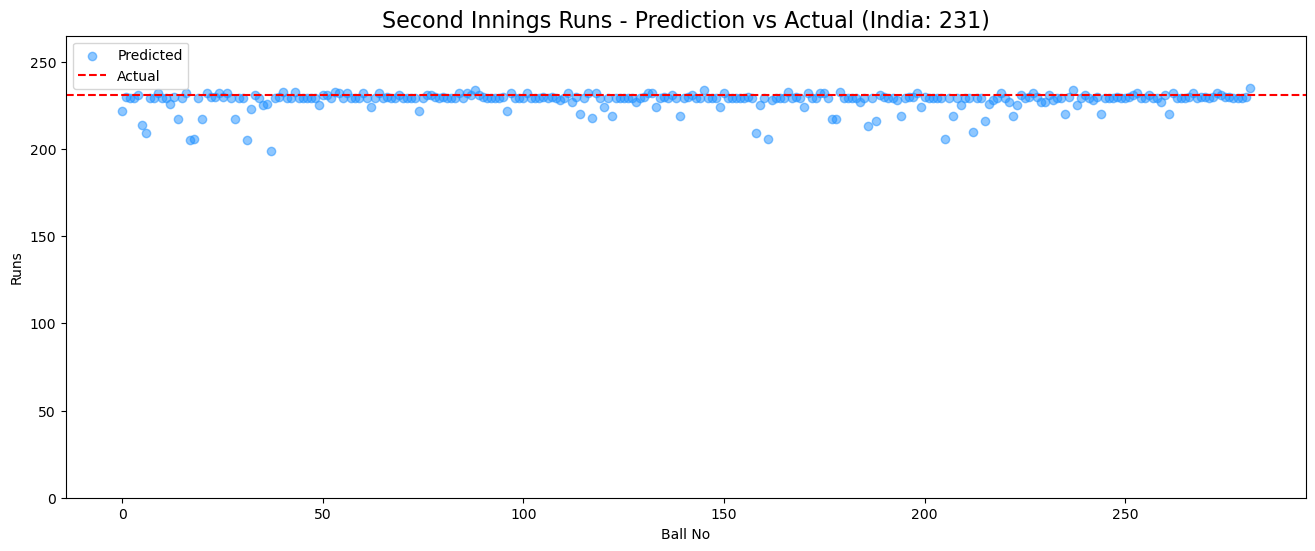

In [76]:
# Predict final score for each ball in the second innings (India).
ing2_runs_pred = []
curr_score = 0
curr_wickets = 0
curr_overs = 0.0

for i in range(len(df_ing2)):
    curr_score += df_ing2.loc[i, 'total_runs']
    curr_wickets += df_ing2.loc[i, 'isOut']
    curr_overs = df_ing2.loc[i, 'ball']
    
    prediction = innings_2_runs(curr_overs, curr_score, curr_wickets, target)
    ing2_runs_pred.append(prediction)

# Plot the second innings runs prediction.
plt.figure(figsize=(16, 6))
# Scatter plot in DODGERBLUE for predicted runs.
plt.scatter(range(len(ing2_runs_pred)), ing2_runs_pred, alpha=0.5, color='dodgerblue', label='Predicted')
# Actual final score shown as a RED horizontal line.
plt.axhline(ing2_actual_score, linestyle='--', color='red', label='Actual')
plt.ylim(0, max(ing2_actual_score, max(ing2_runs_pred)) + 30)
plt.title(f'Second Innings Runs - Prediction vs Actual ({t2}: {ing2_actual_score})', fontsize=16)
plt.xlabel('Ball No')
plt.ylabel('Runs')
plt.legend()
plt.show()

## Error in 2nd Innings runs:

In [77]:
# Calculate and print the mean absolute error for the second innings predictions.
error_ing2 = np.mean([abs(x - ing2_actual_score) for x in ing2_runs_pred])
print("Error in 2nd Innings runs:", error_ing2)

Error in 2nd Innings runs: 3.5319148936170213


## Win Predictions – 1st Innings Simulation

In [78]:
# For each ball in the first innings, simulate win predictions.
win_count_ls = []
tie_count_ls = []
lose_count_ls = []

ing1_curr_score = 0
ing1_curr_overs = 0.0
ing1_curr_wickets = 0

for i in range(len(df_ing1)):
    ing1_curr_score += df_ing1.loc[i, 'total_runs']
    ing1_curr_overs = df_ing1.loc[i, 'ball']
    ing1_curr_wickets += df_ing1.loc[i, 'isOut']
    
    win_count = 0
    tie_count = 0
    lose_count = 0
    
    # Run 100 simulations from the current state.
    for j in range(100):
        # Predict Bangladesh's final score from the current state.
        t1_final = innings_1_runs(ing1_curr_overs, ing1_curr_score, ing1_curr_wickets)
        # Simulate India's chase from the start (0 runs, 0 wickets, 0 overs) with target = t1_final + 1.
        t2_final = innings_2_runs(0.0, 0, 0, t1_final + 1)
        
        if t2_final > t1_final:
            win_count += 1
        elif t2_final == t1_final:
            tie_count += 1
        else:
            lose_count += 1
    
    win_count_ls.append(win_count)
    tie_count_ls.append(tie_count)
    lose_count_ls.append(lose_count)


## Win Predictions – 2nd Innings Simulation

In [79]:
# For the second innings, accumulate India's state ball-by-ball and run simulations.
for i in range(len(df_ing2)):
    # Accumulate India's cumulative state up to ball i.
    current_score = df_ing2.loc[i, 'total_runs']
    current_wickets = df_ing2.loc[i, 'isOut']
    current_overs = df_ing2.loc[i, 'ball']
    
    if i > 0:
        # Sum previous balls for cumulative state.
        current_score += sum(df_ing2.loc[:i-1, 'total_runs'])
        current_wickets += sum(df_ing2.loc[:i-1, 'isOut'])
    
    win_count = 0
    tie_count = 0
    lose_count = 0
    
    for j in range(100):
        # Simulate India's final score from the current cumulative state.
        t2_final = innings_2_runs(current_overs, current_score, current_wickets, ing1_actual_score + 1)
        
        if t2_final > ing1_actual_score:
            win_count += 1
        elif t2_final == ing1_actual_score:
            tie_count += 1
        else:
            lose_count += 1
    
    win_count_ls.append(win_count)
    tie_count_ls.append(tie_count)
    lose_count_ls.append(lose_count)

## Win Percentage Chart:

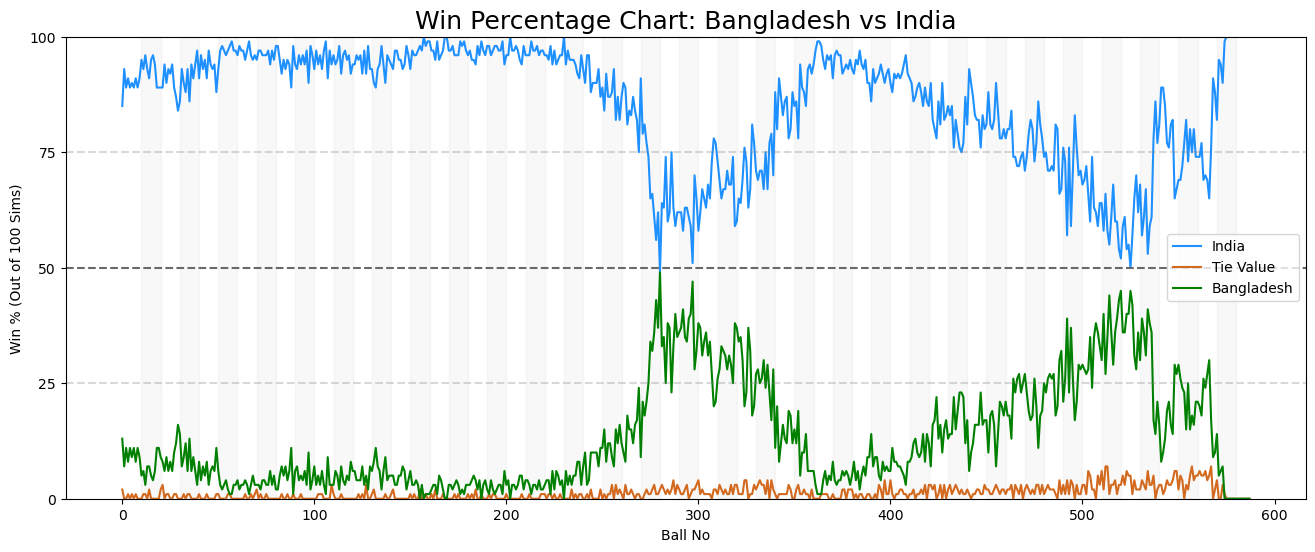

In [80]:
plt.figure(figsize=(16, 6))
x_vals = list(range(len(win_count_ls)))

# Plot win percentages for India, tie values, and losses (which represent Bangladesh wins).
plt.plot(x_vals, win_count_ls, color='dodgerblue', label=t2)   # India's wins
plt.plot(x_vals, tie_count_ls, color='chocolate', label='Tie Value')
plt.plot(x_vals, lose_count_ls, color='green', label=t1)        # Bangladesh wins

# Optional vertical shading for segmentation.
for i in range(10, len(x_vals), 20):
    if i < len(x_vals) - 10:
        plt.axvspan(i, i+10, ymin=0, ymax=100, alpha=0.05, color='grey')

# Horizontal reference lines.
plt.axhline(y=75, ls='--', alpha=0.3, c='grey')
plt.axhline(y=50, ls='--', alpha=1, c='dimgrey')
plt.axhline(y=25, ls='--', alpha=0.3, c='grey')

plt.ylim(0, 100)
plt.yticks([0, 25, 50, 75, 100])
plt.title(f'Win Percentage Chart: {t1} vs {t2}', fontsize=18)
plt.xlabel('Ball No')
plt.ylabel('Win % (Out of 100 Sims)')
plt.legend()
plt.show()